In [1]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [2]:
# ============================
# 2. Dataset & Dataloaders
# ============================

# Transforms for Inception v4 (input size = 299x299)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Path to dataset
data_dir = "/kaggle/input/cucumber-disease/cucumber_disease"

# Load datasets separately to avoid transform overwrite
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# Apply different transforms for train/val
train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Classes
class_names = full_dataset.classes
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Pythium Fruit Rot']
Train samples: 1129, Val samples: 1129


In [3]:
# ============================
# 3. Model, Loss, Optimizer
# ============================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models  # Inception v3 comes from torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained Inception v3
model = models.inception_v3(weights=None)  # pretrained on ImageNet

# Replace classifier (Aux logits + FC for main output)
num_classes = len(class_names)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [4]:
# ============================
# 4. Training & Validation Loop (Fixed for Inception v3 + tqdm integration)
# ============================
from torchvision.models.inception import InceptionOutputs  # ✅ for inception outputs
from tqdm import tqdm  # ✅ added from Block 2

num_epochs = 20
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0.0  # track best model

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0, 0, 0

    # ✅ Wrap training loader with tqdm (from Block 2)
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Handle Inception v3 output during training
        if isinstance(outputs, InceptionOutputs):
            loss1 = criterion(outputs.logits, labels)     # main classifier
            loss2 = criterion(outputs.aux_logits, labels) # aux classifier
            loss = loss1 + 0.4 * loss2                   # weighted sum
            preds = outputs.logits
        else:
            loss = criterion(outputs, labels)
            preds = outputs

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = preds.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        # tqdm bar update
        train_pbar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # ---- Validation ----
    model.eval()
    running_loss, correct, total = 0, 0, 0

    # ✅ Wrap validation loader with tqdm (from Block 2)
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle Inception v3 output during validation
            if isinstance(outputs, InceptionOutputs):
                preds = outputs.logits
                loss = criterion(preds, labels)
            else:
                preds = outputs
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = preds.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # tqdm bar update
            val_pbar.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = 100 * correct / total

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # ✅ Save best model (kept from Block 1)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_inceptionv3.pth")

    # ✅ Epoch summary (kept from Block 1)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch [1/20] Train Loss: 2.3340, Train Acc: 40.30% Val Loss: 1.3840, Val Acc: 53.85%


Epoch [2/20] Train Loss: 1.5545, Train Acc: 62.00% Val Loss: 0.7999, Val Acc: 74.05%


Epoch [3/20] Train Loss: 1.1303, Train Acc: 69.71% Val Loss: 0.6005, Val Acc: 77.50%


Epoch [4/20] Train Loss: 0.8958, Train Acc: 77.50% Val Loss: 0.4632, Val Acc: 82.64%


Epoch [5/20] Train Loss: 0.7633, Train Acc: 79.72% Val Loss: 0.4148, Val Acc: 83.61%


Epoch [6/20] Train Loss: 0.7023, Train Acc: 81.13% Val Loss: 0.4068, Val Acc: 83.88%


Epoch [7/20] Train Loss: 0.6445, Train Acc: 81.75% Val Loss: 0.3095, Val Acc: 87.33%


Epoch [8/20] Train Loss: 0.5445, Train Acc: 85.21% Val Loss: 0.2711, Val Acc: 89.28%


Epoch [9/20] Train Loss: 0.5149, Train Acc: 85.92% Val Loss: 0.2467, Val Acc: 90.17%


Epoch [10/20] Train Loss: 0.4897, Train Acc: 87.33% Val Loss: 0.2188, Val Acc: 92.56%


Epoch [11/20] Train Loss: 0.4363, Train Acc: 87.78% Val Loss: 0.1882, Val Acc: 93.27%


Epoch [12/20] Train Loss: 0.4402, Train Acc: 87.42% Val Loss: 0.1690, Val Acc: 93.98%


Epoch [13/20] Train Loss: 0.3901, Train Acc: 89.99% Val Loss: 0.2058, Val Acc: 93.98%


Epoch [14/20] Train Loss: 0.3572, Train Acc: 90.97% Val Loss: 0.1822, Val Acc: 93.09%


Epoch [15/20] Train Loss: 0.3540, Train Acc: 90.08% Val Loss: 0.2546, Val Acc: 91.76%


Epoch [16/20] Train Loss: 0.3284, Train Acc: 91.05% Val Loss: 0.1342, Val Acc: 95.04%


Epoch [17/20] Train Loss: 0.3613, Train Acc: 89.90% Val Loss: 0.2233, Val Acc: 92.03%


Epoch [18/20] Train Loss: 0.2870, Train Acc: 92.12% Val Loss: 0.1448, Val Acc: 95.57%


Epoch [19/20] Train Loss: 0.2788, Train Acc: 92.65% Val Loss: 0.0781, Val Acc: 97.79%


Epoch [20/20] Train Loss: 0.2272, Train Acc: 94.69% Val Loss: 0.0986, Val Acc: 95.48%

Training complete. Best Validation Accuracy: 97.79%


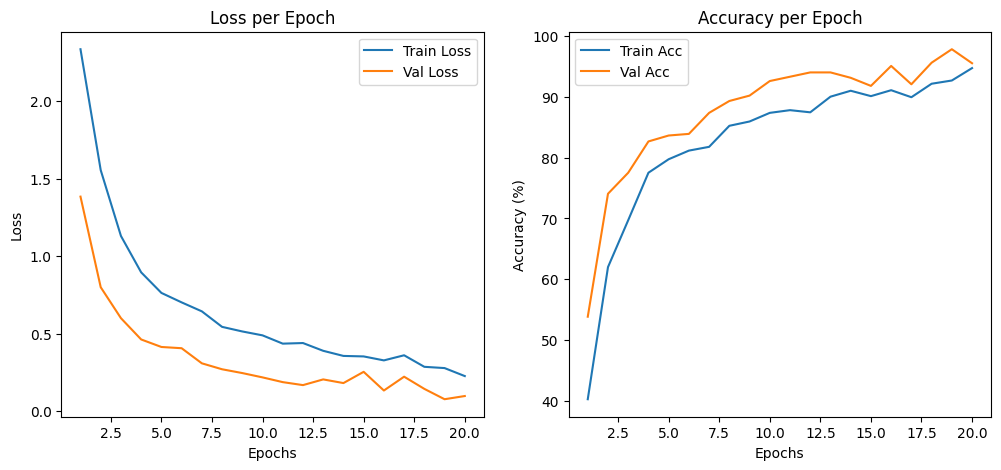

In [5]:
# ============================
# 5. Training History Plots
# ============================
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()


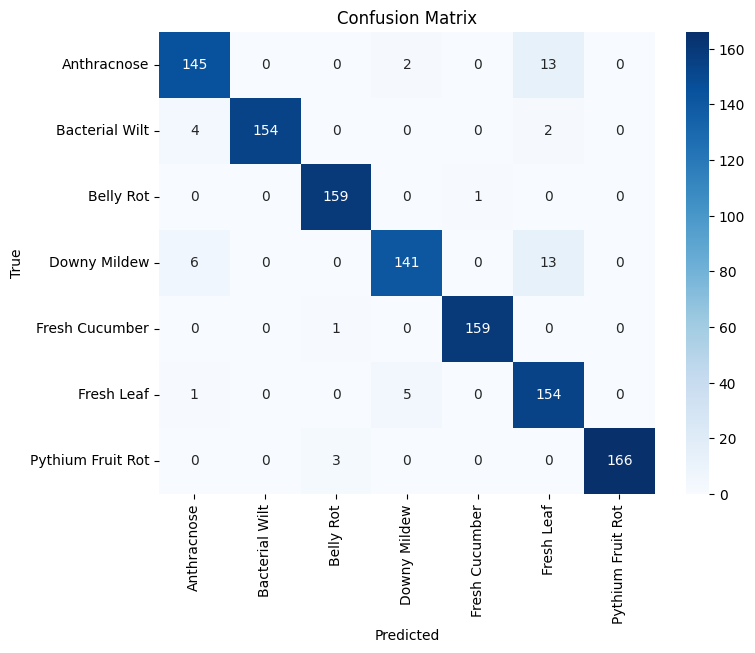


Classification Report:

                   precision    recall  f1-score   support

      Anthracnose       0.93      0.91      0.92       160
   Bacterial Wilt       1.00      0.96      0.98       160
        Belly Rot       0.98      0.99      0.98       160
     Downy Mildew       0.95      0.88      0.92       160
   Fresh Cucumber       0.99      0.99      0.99       160
       Fresh Leaf       0.85      0.96      0.90       160
Pythium Fruit Rot       1.00      0.98      0.99       169

         accuracy                           0.95      1129
        macro avg       0.96      0.95      0.95      1129
     weighted avg       0.96      0.95      0.96      1129



In [6]:
# ============================
# 6. Evaluation: Confusion Matrix & Report
# ============================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
